# *Análisis del Sensado de Corriente*

La señal de corriente de frecuencia $f=50$ Hz con sus armónicos se puede definir como:

$ I_i(t)=A_1\cdot sin(2\pi\cdot f\cdot t) + \sum \limits _{n=2}^{\infty} A_n\cdot sin(2\pi\cdot n \cdot f \cdot t)$

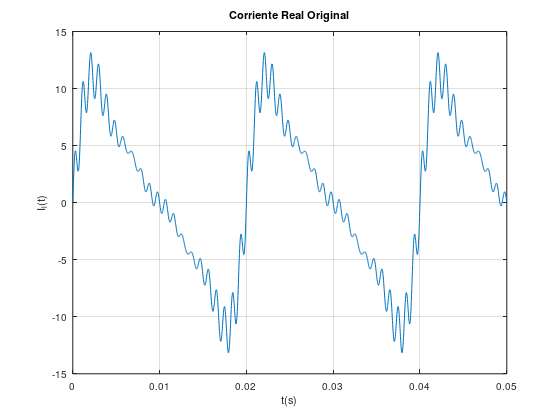

In [17]:
f = 50; % frecuencia fundamental
fs = 40e3; % frecuencia de muestreo
dt = 1/fs; % periodo de muestreo
t = 0:dt:0.05;
A = [8, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.8, 0.6]; % amplitud fundamental y armónicos
Ii = 0;
for n = 1:length(A),
   Ii = Ii + A(n)*sin(2*pi*n*t*f); % inicialización señal de corriente
end;
plot(t,Ii);
title('Corriente Real Original');
grid 'on';
xlabel('t(s)');
ylabel('I_i(t)');

La transconductancia del sensor la convierte en tensión, quedando:

$ I_i(t) \cdot \frac{1V}{10A} = V_i(t) $

$ V_i(t)=\frac{A_1}{10}\cdot sin(2\pi\cdot f \cdot t) + \frac{1}{10}\sum\limits _{n=2}^{\infty} A_n\cdot sin(2\pi\cdot n \cdot f \cdot t) $

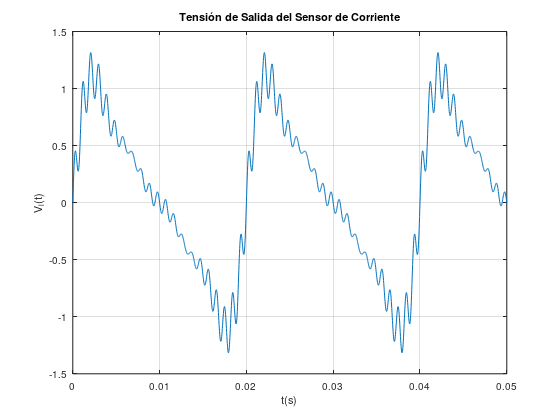

In [52]:
Gm = 0.1; % transconductancia del sensor de corriente
Vi = 0;
for n = 1:length(A),
   Vi = Vi + Gm*A(n)*sin(2*pi*n*t*f); % aplico la transconductancia a la señal
end;
plot(t,Vi);
title('Tensión de Salida del Sensor de Corriente');
grid 'on';
xlabel('t(s)');
ylabel('V_i(t)');

Suponiendo que el filtro antialiasing al tener una frecuencia de corte en $ f_c=1.5 $ KHz no modifica la amplitud de los primeros 20 armónicos y elimina los demás, la tensión luego del filtro entonces se puede expresar como:

$ V_i(t) = \frac{A_1}{10}\cdot sin(2\pi\cdot f \cdot t) + \frac{1}{10}\sum\limits _{n=2}^{20} A_n\cdot sin(2\pi\cdot n\cdot f\cdot t) $

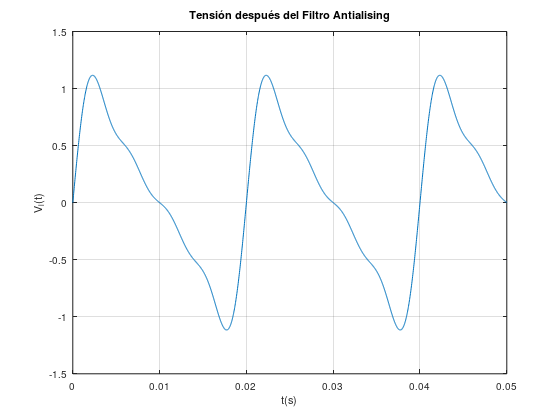

In [53]:
Vi = 0;
for n = 1:20,
   Vi = Vi + Gm*A(n)*sin(2*pi*n*t*f); % Elimino los armónicos que filtramos
end;
plot(t,Vi);
title('Tensión después del Filtro Antialising');
grid 'on';
xlabel('t(s)');
ylabel('V_i(t)');

Al añadirle el offset de 1.5V nos queda:

$ V_i(t) = \frac{A_1}{10}\cdot sin(2\pi\cdot f \cdot t) + \frac{1}{10}\sum\limits _{n=2}^{20} A_n\cdot sin(2\pi\cdot n\cdot f\cdot t) + 1.5 $

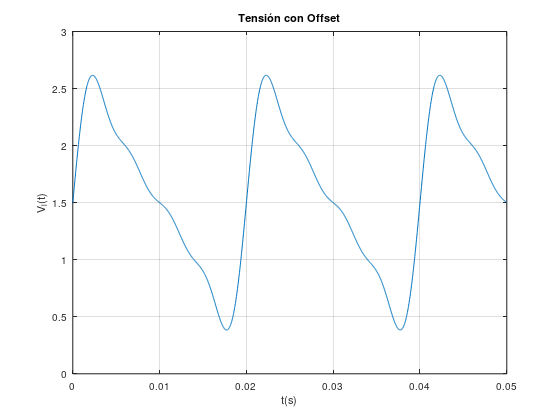

In [54]:
Vi = Vi + 1.5; % añado el offset a la señal
plot(t,Vi);
grid 'on';
title('Tensión con Offset');
xlabel('t(s)');
ylabel('V_i(t)');

La ganancia del amplificador afecta solamente a la componente de alterna, el offset no se ve afectado. Teniendo en cuenta que la ganancia solo varía según la posición del punto medio del potenciómetro digital, esta se puede definir como:

$ G(D_n) = \frac{256}{256-D_n} $

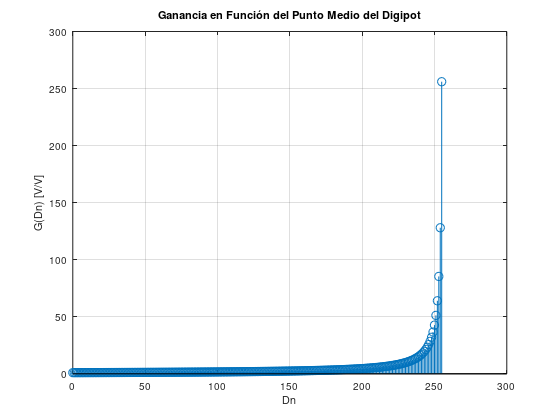

In [55]:
Dn = 0:1:255; % el valor de Dn puede ser cualquier número entero entre 0 y 255, debido a las 256 posiciones del punto medio del digipot
for n = 1:256
    G(n) = 256/(256-Dn(n));
end
stem(Dn,G);
title('Ganancia en Función del Punto Medio del Digipot');
ylabel('G(Dn) [V/V]');
xlabel('Dn');
grid 'on';

Recordando que el valor de $ D_n $ se ajusta automáticamente para aprovechar al máximo la resolución del ADC, en este caso se usaría $ D_n = 60 $, lo que nos da:

$ G(60) =  \frac{256}{256-60} = 1.3061 $

Por lo tanto, la señal de tensión de salida del circuito sería:

$ V_o(t) = G(60) \cdot \frac{A_1}{10}\cdot sin(2\pi\cdot f \cdot t) + G(60)\cdot \frac{1}{10}\sum\limits _{n=2}^{20} A_n\cdot sin(2\pi\cdot n\cdot f\cdot t) + 1.5 $

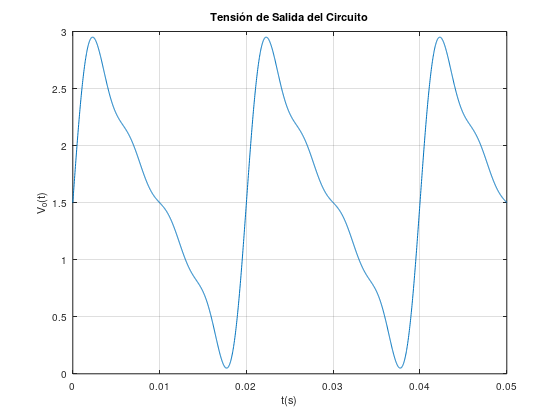

In [56]:
Vo = (Vi - 1.5) * G(60) + 1.5; % aplico la ganancia únicamente a las componentes alternas
plot(t,Vo);
title('Tensión de Salida del Circuito');
grid 'on';
xlabel('t(s)');
ylabel('V_o(t)');

Al muestrear esta señal con el ADC configurado para funcionar con un buffer de 8 bits y una frecuencia de muestreo de 40 KHz, la señal se vería de la siguiente manera:

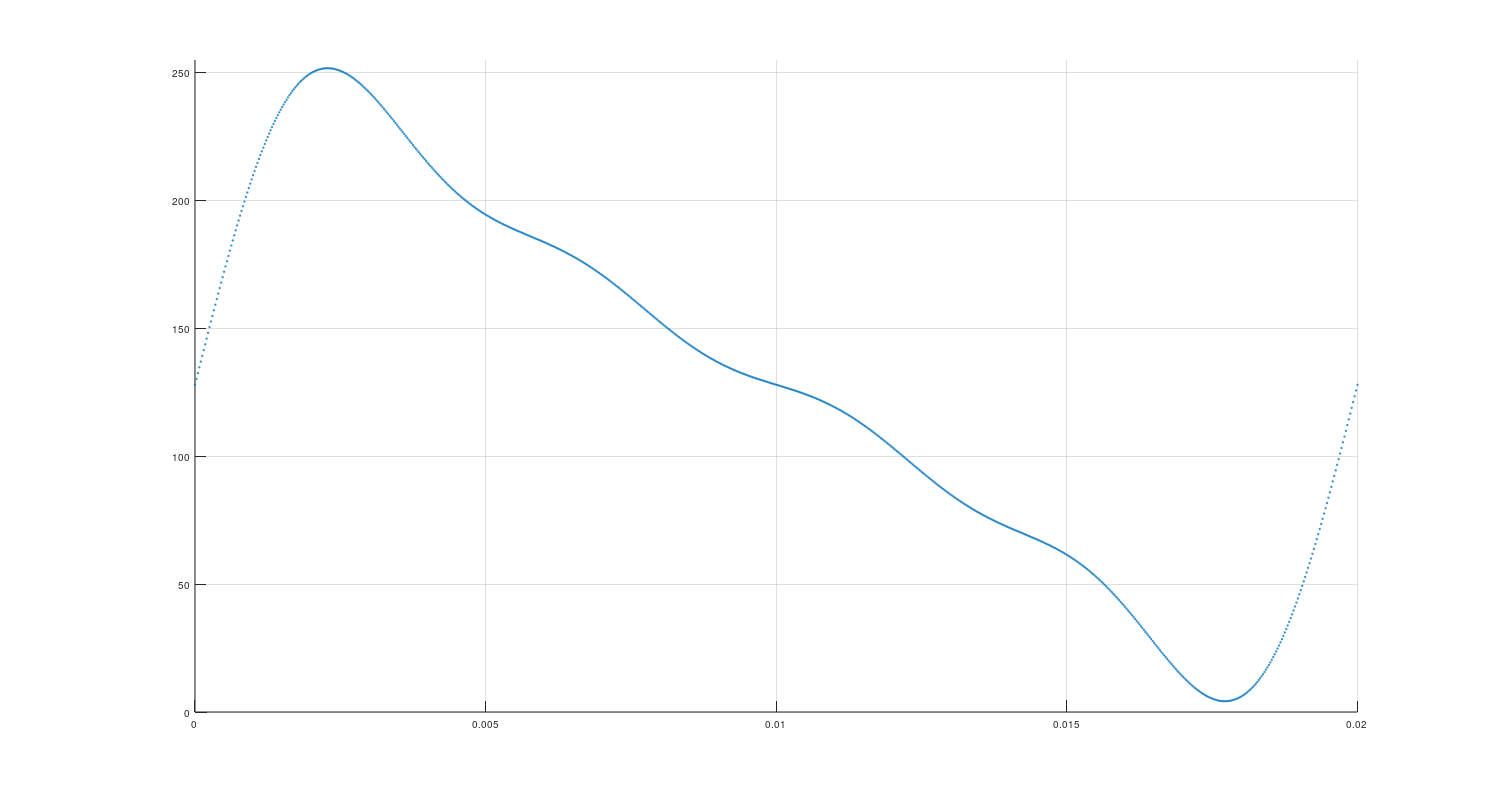

fatal: caught signal Aborted -- stopping myself...


In [58]:
adc_scale = 256/3; % factor de escala al usar 8 bits
Vo_adc = adc_scale * Vo; % aplico el factor de escala

% grafico de forma que se note la discretización
figure;
scatter(t,Vo_adc,1);
set(gcf, 'Position', [0,0,1500,800]);
xlim([0,0.02]);
ylim([0,255]);
grid 'on';

## **Tabla de Valores de la Ganancia** 

| $ D_n $ | $ G(D_n) $ |
|---------|------------|
| 0       | 1.0        |
| 1       | 1.0039     |
| 2       | 1.0079     |
| 3       | 1.0119     |
| 4       | 1.0159     |
| 5       | 1.0199     |
| 6       | 1.024      |
| 7       | 1.0281     |
| 8       | 1.0323     |
| 9       | 1.0364     |
| 10      | 1.0407     |
| 11      | 1.0449     |
| 12      | 1.0492     |
| 13      | 1.0535     |
| 14      | 1.0579     |
| 15      | 1.0622     |
| 16      | 1.0667     |
| 17      | 1.0711     |
| 18      | 1.0756     |
| 19      | 1.0802     |
| 20      | 1.0847     |
| 21      | 1.0894     |
| 22      | 1.094      |
| 23      | 1.0987     |
| 24      | 1.1034     |
| 25      | 1.1082     |
| 26      | 1.113      |
| 27      | 1.1179     |
| 28      | 1.1228     |
| 29      | 1.1278     |
| 30      | 1.1327     |
| 31      | 1.1378     |
| 32      | 1.1429     |
| 33      | 1.148      |
| 34      | 1.1532     |
| 35      | 1.1584     |
| 36      | 1.1636     |
| 37      | 1.1689     |
| 38      | 1.1743     |
| 39      | 1.1797     |
| 40      | 1.1852     |
| 41      | 1.1907     |
| 42      | 1.1963     |
| 43      | 1.2019     |
| 44      | 1.2075     |
| 45      | 1.2133     |
| 46      | 1.219      |
| 47      | 1.2249     |
| 48      | 1.2308     |
| 49      | 1.2367     |
| 50      | 1.2427     |
| 51      | 1.2488     |
| 52      | 1.2549     |
| 53      | 1.2611     |
| 54      | 1.2673     |
| 55      | 1.2736     |
| 56      | 1.28       |
| 57      | 1.2864     |
| 58      | 1.2929     |
| 59      | 1.2995     |
| 60      | 1.3061     |
| 61      | 1.3128     |
| 62      | 1.3196     |
| 63      | 1.3264     |
| 64      | 1.3333     |
| 65      | 1.3403     |
| 66      | 1.3474     |
| 67      | 1.3545     |
| 68      | 1.3617     |
| 69      | 1.369      |
| 70      | 1.3763     |
| 71      | 1.3838     |
| 72      | 1.3913     |
| 73      | 1.3989     |
| 74      | 1.4066     |
| 75      | 1.4144     |
| 76      | 1.4222     |
| 77      | 1.4302     |
| 78      | 1.4382     |
| 79      | 1.4463     |
| 80      | 1.4545     |
| 81      | 1.4629     |
| 82      | 1.4713     |
| 83      | 1.4798     |
| 84      | 1.4884     |
| 85      | 1.4971     |
| 86      | 1.5059     |
| 87      | 1.5148     |
| 88      | 1.5238     |
| 89      | 1.5329     |
| 90      | 1.5422     |
| 91      | 1.5515     |
| 92      | 1.561      |
| 93      | 1.5706     |
| 94      | 1.5802     |
| 95      | 1.5901     |
| 96      | 1.6        |
| 97      | 1.6101     |
| 98      | 1.6203     |
| 99      | 1.6306     |
| 100     | 1.641      |
| 101     | 1.6516     |
| 102     | 1.6623     |
| 103     | 1.6732     |
| 104     | 1.6842     |
| 105     | 1.6954     |
| 106     | 1.7067     |
| 107     | 1.7181     |
| 108     | 1.7297     |
| 109     | 1.7415     |
| 110     | 1.7534     |
| 111     | 1.7655     |
| 112     | 1.7778     |
| 113     | 1.7902     |
| 114     | 1.8028     |
| 115     | 1.8156     |
| 116     | 1.8286     |
| 117     | 1.8417     |
| 118     | 1.8551     |
| 119     | 1.8686     |
| 120     | 1.8824     |
| 121     | 1.8963     |
| 122     | 1.9104     |
| 123     | 1.9248     |
| 124     | 1.9394     |
| 125     | 1.9542     |
| 126     | 1.9692     |
| 127     | 1.9845     |
| 128     | 2.0        |
| 129     | 2.0157     |
| 130     | 2.0317     |
| 131     | 2.048      |
| 132     | 2.0645     |
| 133     | 2.0813     |
| 134     | 2.0984     |
| 135     | 2.1157     |
| 136     | 2.1333     |
| 137     | 2.1513     |
| 138     | 2.1695     |
| 139     | 2.188      |
| 140     | 2.2069     |
| 141     | 2.2261     |
| 142     | 2.2456     |
| 143     | 2.2655     |
| 144     | 2.2857     |
| 145     | 2.3063     |
| 146     | 2.3273     |
| 147     | 2.3486     |
| 148     | 2.3704     |
| 149     | 2.3925     |
| 150     | 2.4151     |
| 151     | 2.4381     |
| 152     | 2.4615     |
| 153     | 2.4854     |
| 154     | 2.5098     |
| 155     | 2.5347     |
| 156     | 2.56       |
| 157     | 2.5859     |
| 158     | 2.6122     |
| 159     | 2.6392     |
| 160     | 2.6667     |
| 161     | 2.6947     |
| 162     | 2.7234     |
| 163     | 2.7527     |
| 164     | 2.7826     |
| 165     | 2.8132     |
| 166     | 2.8444     |
| 167     | 2.8764     |
| 168     | 2.9091     |
| 169     | 2.9425     |
| 170     | 2.9767     |
| 171     | 3.0118     |
| 172     | 3.0476     |
| 173     | 3.0843     |
| 174     | 3.122      |
| 175     | 3.1605     |
| 176     | 3.2        |
| 177     | 3.2405     |
| 178     | 3.2821     |
| 179     | 3.3247     |
| 180     | 3.3684     |
| 181     | 3.4133     |
| 182     | 3.4595     |
| 183     | 3.5068     |
| 184     | 3.5556     |
| 185     | 3.6056     |
| 186     | 3.6571     |
| 187     | 3.7101     |
| 188     | 3.7647     |
| 189     | 3.8209     |
| 190     | 3.8788     |
| 191     | 3.9385     |
| 192     | 4.0        |
| 193     | 4.0635     |
| 194     | 4.129      |
| 195     | 4.1967     |
| 196     | 4.2667     |
| 197     | 4.339      |
| 198     | 4.4138     |
| 199     | 4.4912     |
| 200     | 4.5714     |
| 201     | 4.6545     |
| 202     | 4.7407     |
| 203     | 4.8302     |
| 204     | 4.9231     |
| 205     | 5.0196     |
| 206     | 5.12       |
| 207     | 5.2245     |
| 208     | 5.3333     |
| 209     | 5.4468     |
| 210     | 5.5652     |
| 211     | 5.6889     |
| 212     | 5.8182     |
| 213     | 5.9535     |
| 214     | 6.0952     |
| 215     | 6.2439     |
| 216     | 6.4        |
| 217     | 6.5641     |
| 218     | 6.7368     |
| 219     | 6.9189     |
| 220     | 7.1111     |
| 221     | 7.3143     |
| 222     | 7.5294     |
| 223     | 7.7576     |
| 224     | 8.0        |
| 225     | 8.2581     |
| 226     | 8.5333     |
| 227     | 8.8276     |
| 228     | 9.1429     |
| 229     | 9.4815     |
| 230     | 9.8462     |
| 231     | 10.24      |
| 232     | 10.6667    |
| 233     | 11.1304    |
| 234     | 11.6364    |
| 235     | 12.1905    |
| 236     | 12.8       |
| 237     | 13.4737    |
| 238     | 14.2222    |
| 239     | 15.0588    |
| 240     | 16.0       |
| 241     | 17.0667    |
| 242     | 18.2857    |
| 243     | 19.6923    |
| 244     | 21.3333    |
| 245     | 23.2727    |
| 246     | 25.6       |
| 247     | 28.4444    |
| 248     | 32.0       |
| 249     | 36.5714    |
| 250     | 42.6667    |
| 251     | 51.2       |
| 252     | 64.0       |
| 253     | 85.3333    |
| 254     | 128.0      |
| 255     | 256.0      |
